In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
os.environ["LAMMPS_COMMAND"] ="/home/pleon/mylammps/src/lmp_serial"
os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.slab import initialize_slab, get_adsorption_coords
from mcmc.system import SurfaceSystem

from ase.calculators.lammpsrun import LAMMPS # ase version of LAMMPS
from catkit.gen.adsorption import get_adsorption_sites
from catkit.gen.utils.connectivity import get_cutoff_neighbors
from catkit.gen.utils.graph import connectivity_to_edges
from catkit import Gratoms

from time import perf_counter

In [2]:
# import logging
# logger = logging.getLogger("mcmc.mcmc")
# logger.setLevel(logging.DEBUG)

In [3]:
os.environ["LAMMPS_COMMAND"]

'/home/pleon/mylammps/src/lmp_serial'

Initialize test slab and parameters

In [8]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
alat = 3.6147
chem_pot = 0.0
element = "Cu"

system_settings = {
    "surface_name": 'Cu(100)',
    "relax_atoms": False,
    "optimizer": "FIRE",
    "cutoff": 5.0,
    "calc_name": "kim",
    "lattice_param": {"Cu": alat},
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 0.99, # slowly anneal
    "temperature": 1.0, # in terms of kbT
    "chem_pots": {"Cu": chem_pot},
    "num_sweeps": 50,
    "sweep_size": 16,
}

slab = initialize_slab(alat, elem=element, size=(2, 2, 2), miller=(1, 0, 0))

In [9]:
slab.write("Cu_100_2x2x2.cif")

Get adsorption coordinates (there are only 8 in the new code compared with 16 in the old code)

In [10]:
# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4

connectivity = get_cutoff_neighbors(slab, cutoff=system_settings['cutoff'])
edges = connectivity_to_edges(connectivity)

elem = Gratoms(element)
ads_positions = get_adsorption_coords(
    slab, elem, connectivity, debug=True
)

In [11]:
# from pymatgen.analysis.adsorption import AdsorbateSiteFinder
# from pymatgen.io.ase import AseAtomsAdaptor

# pristine_slab = slab.copy()
# pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
# site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
# ads_positions = site_finder.find_adsorption_sites(
#     put_inside=True, 
#     symm_reduce=False, 
#     near_reduce=system_settings['near_reduce'], 
#     distance=system_settings['planar_distance'], 
#     no_obtuse_hollow=system_settings['no_obtuse_hollow']
# )['all']

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [[ 0.    -0.    19.447]
 [ 2.556  0.    19.447]
 [ 0.     2.556 19.447]
 [ 2.556  2.556 19.447]
 [ 1.278  0.    19.117]]...


Set up LAMMPS (calculator)

In [12]:
# use LAMMPS
optimizer = 'LAMMPS'
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}

# set up the LAMMPS calculator
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir=os.path.join(os.path.expanduser('~'), "tmp_files"))
lammps_calc.set(**parameters)

{'pair_style': 'eam', 'pair_coeff': ['* * Cu_u3.eam']}

Initialize surface system

In [13]:
surface = SurfaceSystem(slab, ads_positions, lammps_calc, system_info=system_settings)

2024-02-05 20:41:39,841|INFO|initial state is [0 0 0 0 0 0 0 0]
2024-02-05 20:41:39,841|INFO|number of pristine atoms is 8
2024-02-05 20:41:39,842|INFO|bulk indices are []
2024-02-05 20:41:39,843|INFO|surface indices are [4 5 6 7]


ads coords is [ 0.    -0.    19.447]
ads coords is [ 2.556  0.    19.447]
ads coords is [ 0.     2.556 19.447]
ads coords is [ 2.556  2.556 19.447]
ads coords is [ 1.278  0.    19.117]
ads coords is [ 3.834  0.    19.117]
ads coords is [ 3.834  2.556 19.117]
ads coords is [ 2.556  1.278 19.117]


In [14]:
surface.all_atoms.write("Cu_100_2x2x2_all_virtual_ads.cif")

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Cu(100)/` folder.

2024-02-05 20:42:12,390|INFO|there are 8 atoms in pristine slab
2024-02-05 20:42:12,392|INFO|Running with num_sweeps = 50, temp = 1.0, pot = [0.0], alpha = 0.99
2024-02-05 20:42:12,393|INFO|In pristine slab, there are a total of 8 sites
/home/dux/miniforge3/envs/htvs/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
2024-02-05 20:42:12,426|INFO|running for 16 iterations per run over a total of 50 runs
2024-02-05 20:42:12,427|INFO|starting with iteration 0
2024-02-05 20:42:12,429|INFO|In sweep 1 out of 50


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


2024-02-05 20:42:12,849|INFO|optim structure has Energy = -31.88241763255948
2024-02-05 20:42:12,855|INFO|In sweep 2 out of 50
2024-02-05 20:42:13,315|INFO|optim structure has Energy = -31.88241763255948
2024-02-05 20:42:13,319|INFO|In sweep 3 out of 50
2024-02-05 20:42:13,763|INFO|optim structure has Energy = -31.88241763255948
2024-02-05 20:42:13,767|INFO|In sweep 4 out of 50
2024-02-05 20:42:14,189|INFO|optim structure has Energy = -31.48116972438692
2024-02-05 20:42:14,194|INFO|In sweep 5 out of 50
2024-02-05 20:42:14,612|INFO|optim structure has Energy = -35.38659967887471
2024-02-05 20:42:14,616|INFO|In sweep 6 out of 50
2024-02-05 20:42:15,107|INFO|optim structure has Energy = -35.38659967887471
2024-02-05 20:42:15,113|INFO|In sweep 7 out of 50
2024-02-05 20:42:15,636|INFO|optim structure has Energy = -35.38659967887471
2024-02-05 20:42:15,642|INFO|In sweep 8 out of 50
2024-02-05 20:42:16,120|INFO|optim structure has Energy = -35.38659967887471
2024-02-05 20:42:16,124|INFO|In sw

Time taken = 24.017473445739597 seconds


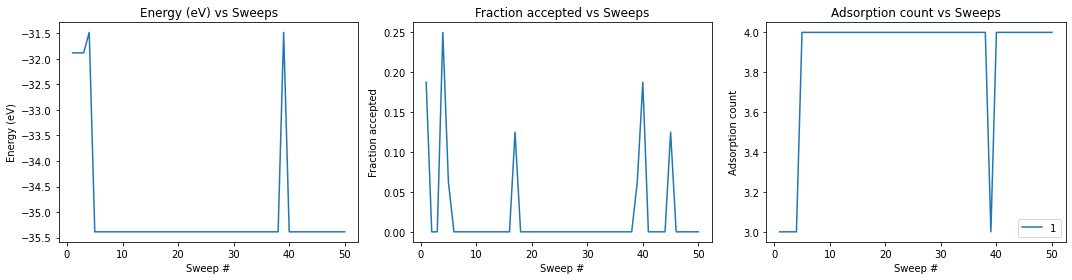

In [15]:
mcmc = MCMC(system_settings['surface_name'], calc=lammps_calc, canonical=False, testing=False, 
            element=element, adsorbates=list(sampling_settings['chem_pots'].keys()), 
            relax=False, optimizer=optimizer) # no relaxation

start = perf_counter()
# call the main function
# TODO: convert to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings['num_sweeps'],
    sweep_size=sampling_settings['sweep_size'],
    start_temp=sampling_settings['temperature'],
    pot=list(sampling_settings['chem_pots'].values()),
    alpha=sampling_settings['alpha'],
    surface=surface
    )

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")